In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_pacf

from utils.trainer import Trainer, ARIMATrainer
from utils.tuner import ARIMATuner
from utils.pairs import PairsFinder
from utils.trader import AutoTrader

## **Exploratory Analysis**

Selected pairs: [('AAPL', 'LNVGY'), ('AMD', 'IBM'), ('AMD', 'DELL'), ('AMD', 'LNVGY')]


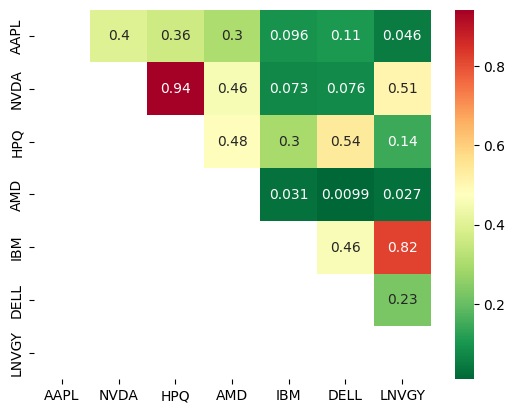

In [2]:
stocks = ['AAPL', 'NVDA', 'HPQ', 'AMD', 'IBM', 'DELL', 'LNVGY']

pairs_finder = PairsFinder()

pairs = pairs_finder.plot_coint_heatmap(stocks)

print(f'Selected pairs: {pairs}')


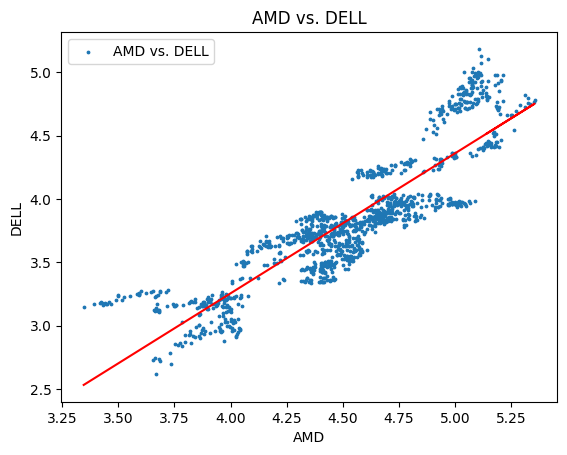

In [3]:
pair = ('AMD', 'DELL')

pairs_finder.plot_hedge_ratio(pair)

plt.title('AMD vs. DELL')

plt.show()

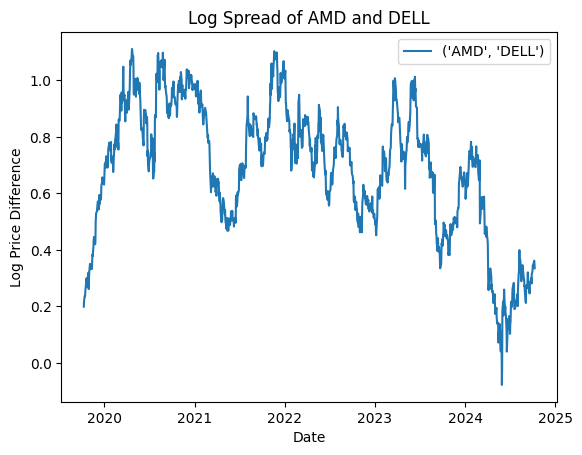

In [4]:
pairs_finder.plot_spread(pair)
plt.title('Log Spread of AMD and DELL')
plt.show()

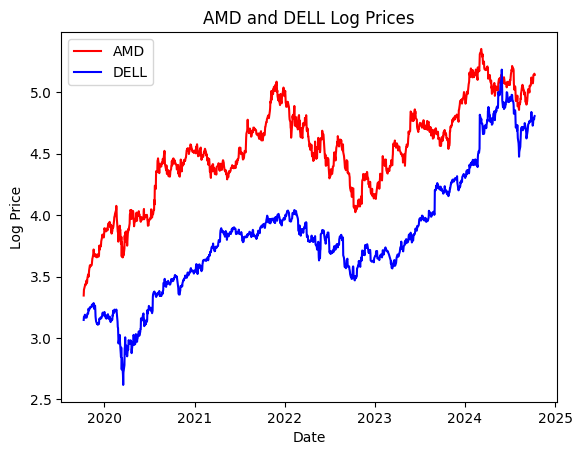

In [5]:
amd = np.log(yf.Ticker('AMD').history(period='5y')['Close'])
dell = np.log(yf.Ticker('DELL').history(period='5y')['Close'])

plt.plot(amd.index, amd, label='AMD', color='red')
plt.plot(dell.index, dell, label='DELL', color='blue')

plt.title('AMD and DELL Log Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')

plt.legend()

plt.show()

p-value of ADF test: 0.08928187001799598


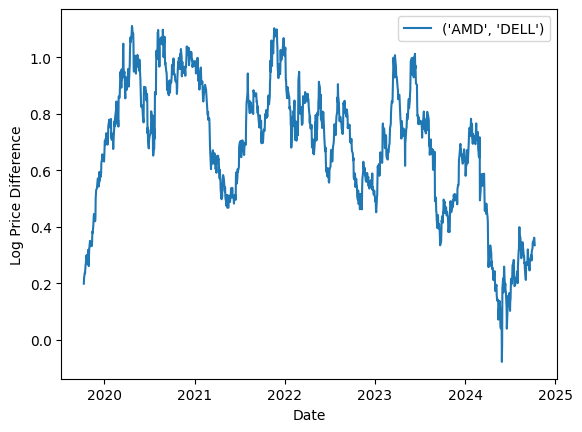

In [6]:
pair = ('AMD', 'DELL')

pairs_finder.plot_spread(pair)

spread = pairs_finder.get_spread(pair)

spread_train, spread_test = train_test_split(
    spread,
    test_size=0.2,
    train_size=0.8,
    shuffle=False
)

trainer = Trainer()

_ = trainer.is_stationary(spread)

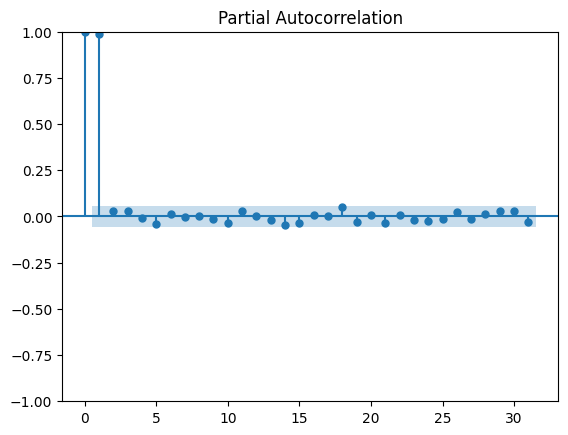

In [7]:
plot_pacf(spread)

plt.show()

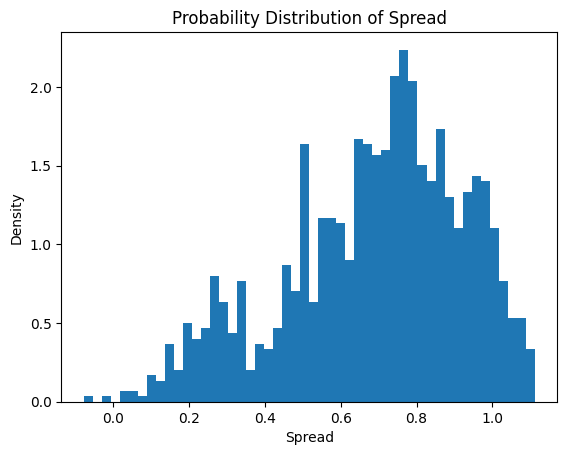

In [8]:
spread_list = spread.reset_index()['Close'].to_list()


spread_list.sort()

plt.hist(spread_list, bins=50, density=True)

plt.title('Probability Distribution of Spread')

plt.xlabel('Spread')
plt.ylabel('Density')

plt.show()

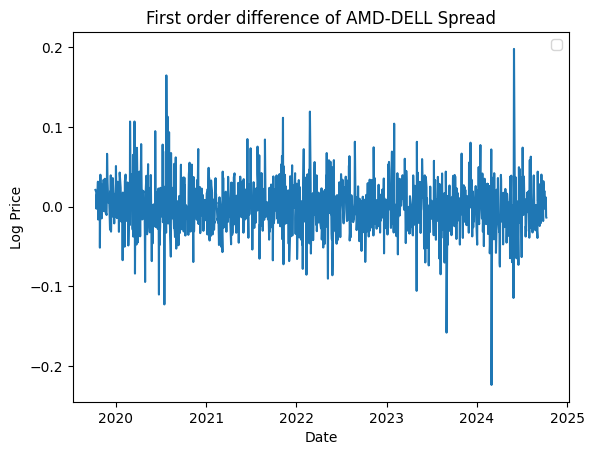

In [9]:
plt.plot(spread.diff(1))

# _ = trainer.is_stationary(spread.diff(1).dropna(inplace=True))

plt.title('First order difference of AMD-DELL Spread')
plt.xlabel('Date')
plt.ylabel('Log Price')

plt.legend()
plt.show()

## **Tuning ARIMA Model**

In [10]:
warnings.filterwarnings(action='ignore')

param_space = {
    'p': [1,2,3,4],
    'q': [1,2,3,4],
    'd': [0, 1, 2]
}

arima_tuner = ARIMATuner()

best_params  = arima_tuner.grid_search(param_space, 'aic', spread_train)

AIC score = -4114.576259293164, cfg = (1, 1, 0)
AIC score = -4112.4210096473635, cfg = (1, 1, 1)
AIC score = -4110.862833834035, cfg = (1, 1, 2)
AIC score = -3678.05144297105, cfg = (1, 2, 0)
AIC score = -4100.77288531041, cfg = (1, 2, 1)
AIC score = -4098.42277165047, cfg = (1, 2, 2)
AIC score = -2847.8330718265406, cfg = (1, 3, 0)
AIC score = -3663.6584218407897, cfg = (1, 3, 1)
AIC score = -4077.2679839751213, cfg = (1, 3, 2)
AIC score = -1869.7579990742652, cfg = (1, 4, 0)
AIC score = -2834.046856396662, cfg = (1, 4, 1)
AIC score = -3346.091035858074, cfg = (1, 4, 2)
AIC score = -4113.074497765676, cfg = (2, 1, 0)
AIC score = -4111.05186624479, cfg = (2, 1, 1)
AIC score = -4111.172667035944, cfg = (2, 1, 2)
AIC score = -3825.755335611319, cfg = (2, 2, 0)
AIC score = -4099.282335271541, cfg = (2, 2, 1)
AIC score = -4096.8318155428415, cfg = (2, 2, 2)
AIC score = -3158.9540749235407, cfg = (2, 3, 0)
AIC score = -3810.5615239858485, cfg = (2, 3, 1)
AIC score = -4070.2257818409034, cfg

In [11]:
print(best_params)

(1, 1, 0)


0.03480419764971716


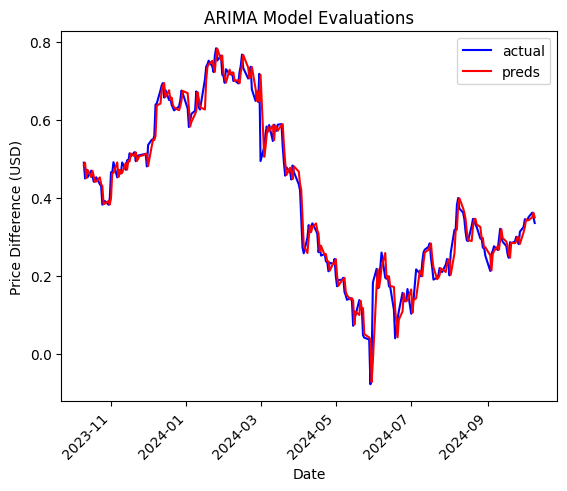

In [12]:
arima_trainer = ARIMATrainer()

preds = arima_trainer.walk_forward_eval(best_params, spread_train, spread_test)

plt.plot(spread_test.index, spread_test, label='actual', color='blue')
plt.plot(spread_test.index, preds, label='preds', color='red')

plt.title('ARIMA Model Evaluations')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')

plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()

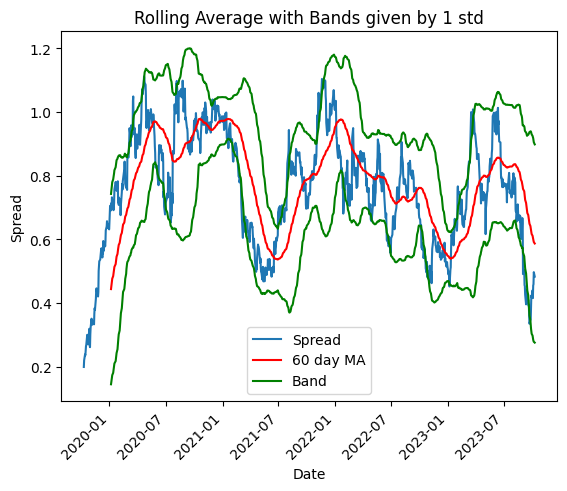

In [13]:
window = 60

train_spread_ma = spread_train.rolling(window=window).mean()
train_spread_std = spread_train.rolling(window=window).std()

upper_band = train_spread_ma + 2 * train_spread_std
lower_band = train_spread_ma - 2 * train_spread_std

plt.plot(spread_train.index, spread_train, label='Spread')

plt.plot(spread_train.index, train_spread_ma, label='60 day MA', color='red')
plt.plot(spread_train.index, upper_band, label='Band', color='green')
plt.plot(spread_train.index, lower_band, color='green')

plt.title('Rolling Average with Bands given by 1 std')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Spread')

plt.legend()
plt.show()

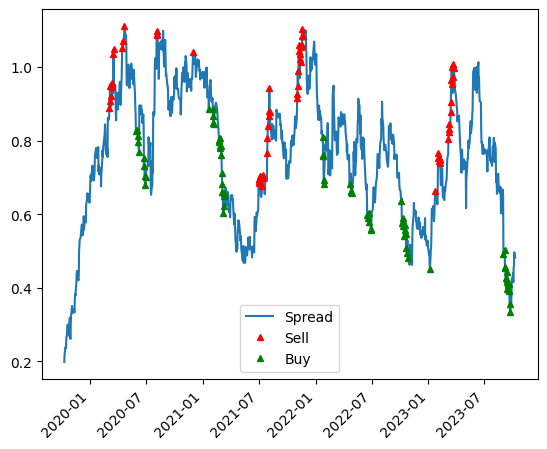

In [14]:
sell = pd.DataFrame(spread_train.copy(), index=spread_train.index)
buy = pd.DataFrame(spread_train.copy(), index=spread_train.index)

sell['sell'] = (spread_train.values >= upper_band.values)
buy['buy'] = (spread_train.values <= lower_band.values)

sell = sell[sell['sell'] == True]
buy = buy[buy['buy'] == True]

plt.plot(spread_train.index, spread_train, label='Spread')
plt.plot(sell.index, sell['Close'], color='r', linestyle='None', marker='^', label='Sell', markersize=5)
plt.plot(buy.index, buy['Close'], color='g', linestyle='None', marker='^', label='Buy', markersize=5)

plt.xticks(rotation=45, ha='right')

plt.legend()

plt.show()

## **Pairs Trading**

In [15]:
amd = yf.Ticker('AMD').history(period='5y')['Close']
dell = yf.Ticker('DELL').history(period='5y')['Close']

trader = AutoTrader(amd, dell, 'AMD', 'DELL', 10000)

money, results = trader.trade(best_params, spread_train, spread_test)

returns = results['pnl'].pct_change()
returns.dropna(inplace=True)
returns = returns.iloc[1:]

annual_ret = (money - 10000)/10000

print(f'Final Balance: ${money}')
print(f'Annual Return: {annual_ret}')
print(f'Average Daily Return: {np.mean(returns)}')
print(f'Annualised Sharpe Ratio: {np.sqrt(252) * np.mean(returns) / np.std(returns)}')

Final Balance: $12679.035659790039
Annual Return: 0.2679035659790039
Average Daily Return: 0.026478550725205108
Annualised Sharpe Ratio: 2.3372625617130134


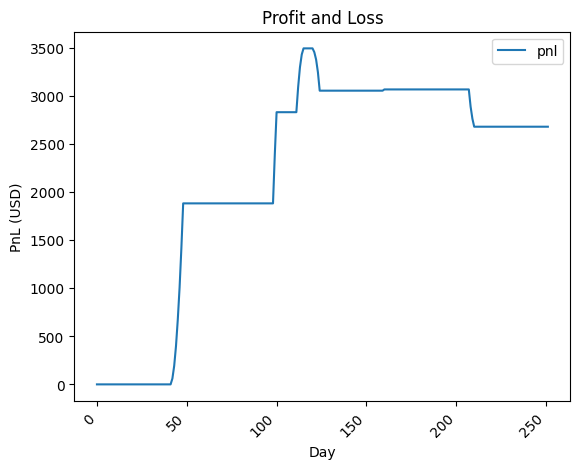

In [16]:
temp = results.copy()
temp.reset_index(inplace=True)

temp['pnl'].plot()

plt.xticks(rotation=45, ha='right')

plt.title('Profit and Loss')
plt.xlabel('Day')
plt.ylabel('PnL (USD)')

plt.legend()

plt.show()

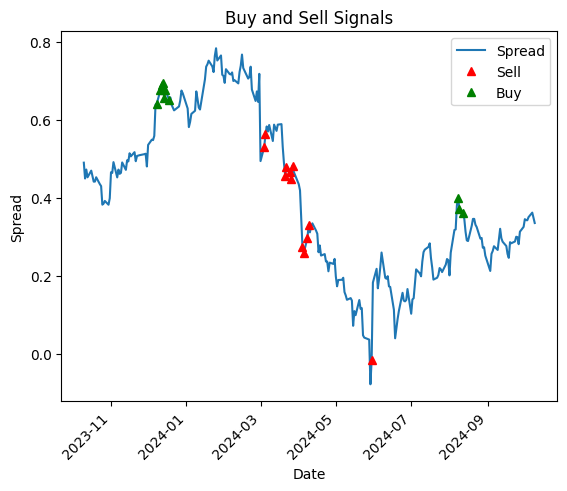

In [17]:
trader.plot_buy_sell(spread_test, results)

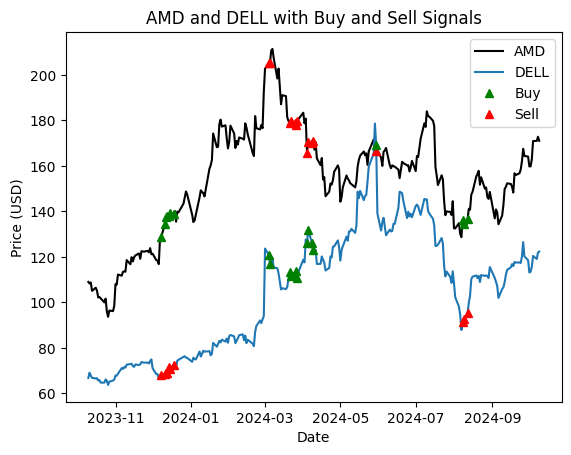

In [18]:
trader.plot_buy_sell_stock(results)